In [3]:
import pymc as pm
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [38]:
import matplotlib.pyplot as plt

# Problem Set Up

We're going to set up a ds problem using the same generative model that we're going to solve it with. This means if we do things right, we should have a really good shot of going "backwards" from our data to discovering the model parameters that created it. Let's try it, and see if it works!

The basic problem is a change point detection problem (in the number of counts per day that we see of something we're measuring). We want to know where the shift in behavior happened from one poisson distribution to another.

following here:
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.ipynb

which stems from: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers 



In [4]:
# gen data

count_data_1 = np.random.poisson(10, 50)
count_data_2 = np.random.poisson(30,20)
count_data = np.concatenate((count_data_1, count_data_2))
count_data
n_count_data = len(count_data)

In [10]:
count_data

array([12, 14, 10, 10,  8, 14,  9, 11,  8,  8, 11,  7,  7,  5,  5, 15, 10,
       11, 14,  6, 14, 11,  6,  8, 12, 12, 11, 12, 11, 13, 12,  9,  6, 12,
       14, 14,  8, 15,  8, 13,  9, 12, 10, 11, 12,  6,  4,  5,  6, 12, 35,
       30, 25, 29, 30, 27, 33, 22, 40, 19, 23, 33, 26, 26, 27, 33, 34, 35,
       27, 26])

^ we have some data! we've set it so there really are two processes here, and the transition point occurs at t=51

In [5]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean() # prior guess for alpha is the inverse of the mean of our data

    # think about how we would generate a hypothetical instance of this data
    lambda_1 = pm.Exponential("lambda_1", alpha) # draw a lambda_1 from our distbution
    lambda_2 = pm.Exponential("lambda_2", alpha) # draw a second lambda we'll use after our switchpoint
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1) # we generate a random switchpoint from a discrete uniform

In [6]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2) # create a lambda composed of lambda_1 and lambda_2

In [7]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)


let's look at our model (model object attributes can be found here: https://www.pymc.io/projects/docs/en/v5.10.2/api/model/generated/pymc.model.core.Model.html)

In [29]:
model.basic_RVs

[lambda_1 ~ Exponential(f()),
 lambda_2 ~ Exponential(f()),
 tau ~ DiscreteUniform(f(), f()),
 obs ~ Poisson(f(lambda_1, lambda_2, tau))]

In [19]:
pm.draw(model.tau) # drawn from prior!

array(26)

In [27]:
pm.draw(lambda_1) # drawn from prior!

array(45.62488181)

In [31]:
pm.draw(observation) # drawn from prior!

array([16, 17, 13, 16, 17, 13, 17, 10, 14, 12, 26, 18, 16, 17, 14, 19, 23,
       24, 17, 17, 19, 16, 18, 19, 16, 14, 19, 20, 13,  8,  8,  6,  5,  3,
        7, 14,  8, 12, 10,  9,  5,  9,  9, 10, 11, 15,  9, 13,  9,  7,  7,
       11, 11,  8,  6,  7,  2, 12, 15, 12, 13,  6, 11,  9, 11, 12, 11,  9,
        3, 11])

ok! let's fit our model!

In [32]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 4 seconds.


In [33]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [37]:
tau_samples # nailed it immediately!

array([50, 50, 50, ..., 50, 50, 50])

# Results 

(Analysis below)
The model totally nailed the right value for tau! It started at 50 and pretty much stuck there, dipping down to 49 a little.
Posterior estimates for lambda 2 were wider than lambda 1, and that makes sense because we had 20 datapoints in the lambda = 30 range and 50 datapoints in the lambda = 10 range. Still, overall our inference totally got the right answer!

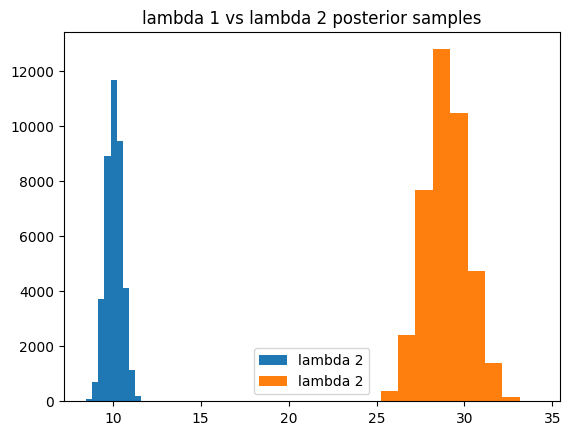

In [46]:
plt.title('lambda 1 vs lambda 2 posterior samples')
plt.hist(lambda_1_samples, label='lambda 2')
plt.hist(lambda_2_samples, label='lambda 2')
plt.legend()

In [51]:
np.min(tau_samples)

49

In [52]:
np.max(tau_samples)

50

In [56]:
np.mean(tau_samples==50) # almost always 50

0.99675